# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib import colors
import sdf
import re
import imageio as imageio
import glob

plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"] = (10, 8)

# Parameters

## The Envelope

The envelope of the incident laser field varies according to
$$
    P(t)=
    \begin{cases}
         & e^{\frac{-(t-T/2)^2}{2(0.2T)^2}} \text{ for } 0 \leq t \le T \\
         & 0         \;      \text{ otherwise }
    \end{cases}
$$

with $T = 20\tau$. See below to see what $\tau$ means and how the envelope looks.

## Physical Constants

In [2]:
m = 9.10938356e-31
e = 1.60217662e-19
c = 299792458
PI = np.pi
epsilon = 8.85e-12

## Constants From Simulation

In [3]:
DATA_DIR = "gaussian"
with open (os.path.join(DATA_DIR, "input.deck"), "r") as myfile:
    data=myfile.read()

FileNotFoundError: [Errno 2] No such file or directory: 'gaussian/input.deck'

The parameters which we want to extract are:
* Wavelength: `lambda`
* Laser Time: `las_time`
* Vector Potential: `a0`
* The density factor: `factor`
* Number of Cells: `nx`
* Simulation End Time: `t_end`
* Size of Box: `x_min`
* dt: `dt_snapshot`

In [4]:
def find_value(info):
    regex = re.compile(rf"\s{info}\s*=\s*-?(\d+\.?\d*)")
    match = regex.search(data)
    if match:
        return float(match.group(1))
    else:
        return None

In [4]:
LAMBD= find_value("lambda0")*1e-6
LAS_TIME = int(find_value("las_time"))
T_MAX = int(find_value("t_end"))
DT = find_value("dt_snapshot")*1e-15
A0 = find_value("a0")
FACTOR = int(find_value("factor"))
NX = int(find_value("nx"))
X_MIN = -int(find_value("x_min"))

print("Values from input.deck:")
print("lambda0 = ", LAMBD)
print("laser_time = ", LAS_TIME)
print("t_end = ", T_MAX)
print("dt_snapshot = ", DT)
print("a0 = ", A0)
print("factor = ", FACTOR)
print("nx = ", NX)
print("x_min = ", X_MIN)

NameError: name 'find_value' is not defined

## Calculated Constants

In [5]:
omega0 = 2*PI*c/LAMBD
tau = 2*PI/omega0
nc = epsilon*m*omega0**2/e**2
Er = m * omega0 * c / e
n0 = FACTOR*nc
LAS_TIME = LAS_TIME*tau
print("Calculated Values for the simulation are:")
print("omega0 = ", omega0)
print("tau = ", tau)
print("nc = ", nc)
print("Er = ", Er)
print("n0 = ", n0)

NameError: name 'LAMBD' is not defined

## Visualizing the Envelope

In [7]:
def get_pulse(t):
    if t<T_P:
        return np.sin(omega0*t)*np.exp(-0.5*((t-0.5*T_P)/(T_P*0.2))**2)
    else:
        return 0

# get_pulse = np.vectorize(get_pulse)

In [8]:
t_max_e = 20*tau
T_P = 20*tau
samples_e = 1000
t_e = np.linspace(0,t_max_e,samples_e)
# P = get_pulse(t_e)
P = [get_pulse(t) for t in t_e]
dt_e = t_e[1]-t_e[0]
f_max_e = 1/dt_e

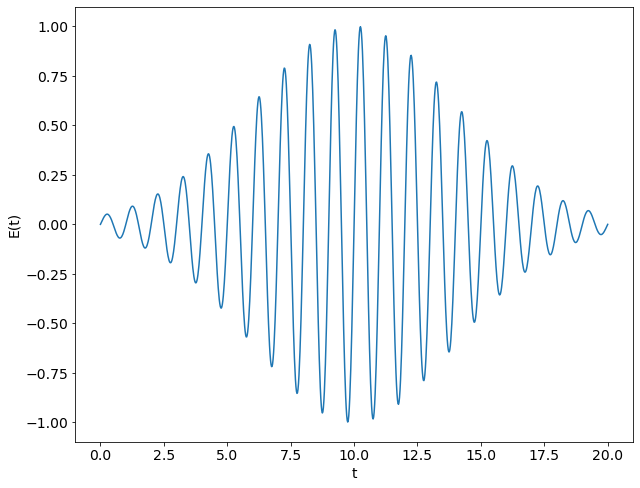

In [9]:
plt.plot(t_e/tau,P)
plt.xlabel('t')
plt.ylabel('E(t)');

We'll also plot its Fourier transform.

In [10]:
f_e = np.linspace(-f_max_e/2,f_max_e/2,samples_e)
omega_e = 2*np.pi*f_e

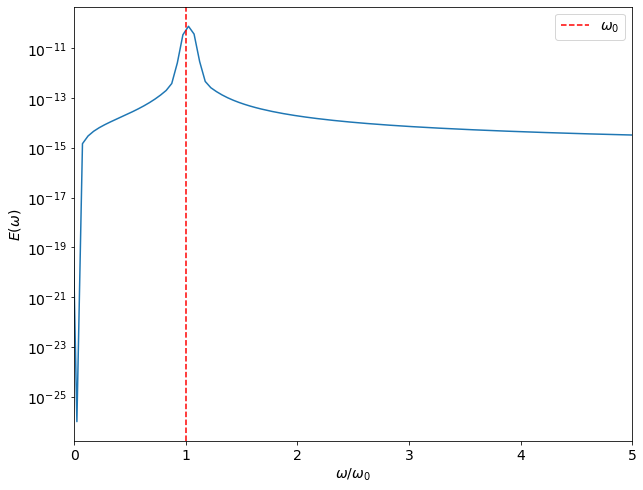

In [11]:
y = np.fft.fft(P)
y = np.fft.fftshift(y)
plt.plot(omega_e/omega0, np.abs(y)/Er)
plt.axvline(1, color='r', linestyle='--', label='$\omega_0$')
plt.yscale('log')
plt.xlim(0, 5)
plt.xlabel('$\omega/\omega_0$')
plt.ylabel('$E(\omega)$')
plt.legend()
plt.show()

## Values for FT

In [12]:
omega_to_resolve = 20*omega0
f_max_to_resolve = omega_to_resolve/(2*PI)
dt_max_to_resolve = 1/(2*f_max_to_resolve)
print(f"The maximum time step for resolution is {dt_max_to_resolve*1e15} femto seconds")

The maximum time step for resolution is 0.08339102379953801 femto seconds


In [13]:
f_max = 1/(DT)
omega_max = 2*np.pi*f_max
omega_max/omega0

41.69551189976901

## Other Variables

In [14]:
ALL_FILES = glob.glob(f"{DATA_DIR}/*sdf")
ALL_FILES.sort()
len(ALL_FILES)

1669

In [15]:
X = np.linspace(X_MIN, -X_MIN, NX)
T = np.linspace(0, T_MAX, len(ALL_FILES))

# Plots and Data

In [16]:
data = sdf.read(ALL_FILES[100])

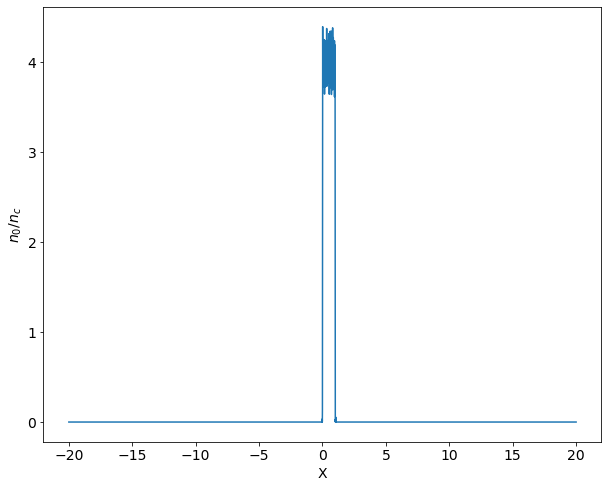

In [17]:
plt.plot(X, data.Derived_Number_Density_Electron.data/nc)
plt.xlabel("X")
plt.ylabel("$n_0/n_c$");

In [18]:
def get_field(id, component="y"):
    raw_data = sdf.read(ALL_FILES[id])
    comp = {
        "x": raw_data.Electric_Field_Ex,
        "y": raw_data.Electric_Field_Ey,
        "z": raw_data.Electric_Field_Ez,
    }
    field = comp[component].data
    return field


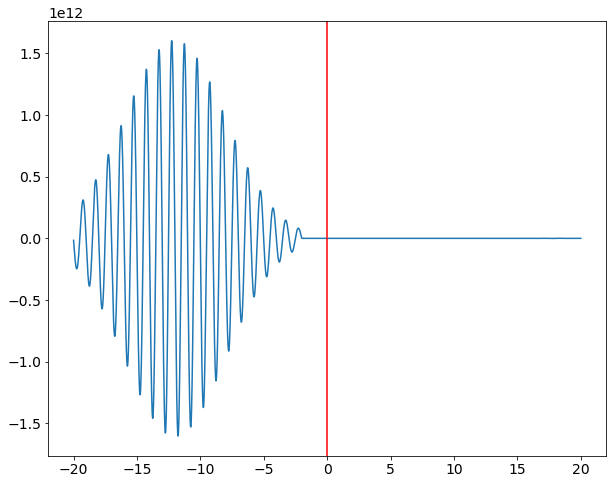

In [19]:
Ey = get_field(750)
plt.plot(X, Ey)
plt.axvline(0, color="red")
plt.show()


In [20]:
Et0 = np.zeros(len(ALL_FILES))
Et1 = np.zeros(len(ALL_FILES))
Et2 = np.zeros(len(ALL_FILES))
d = np.zeros((len(ALL_FILES), NX))
for i in range(len(ALL_FILES)):
    data = sdf.read(ALL_FILES[i])
    ey = data.Electric_Field_Ey.data
    Et0[i] = ey[0]
    Et1[i] = ey[4000]
    Et2[i] = ey[8000]
    d[i] = data.Derived_Number_Density_Electron.data

In [21]:
d.shape, Et0.shape

((1669, 16000), (1669,))

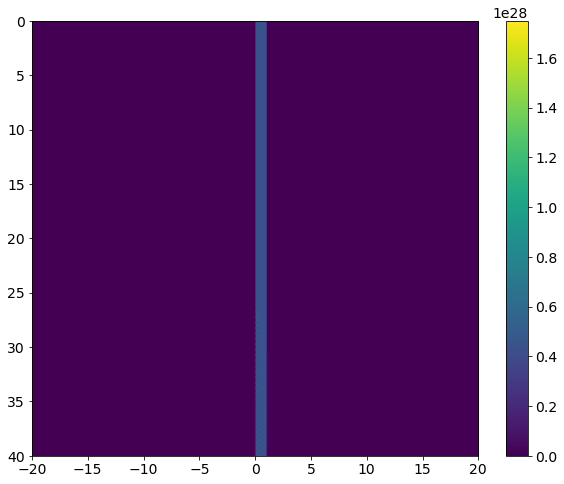

In [22]:
EXTENT = [X_MIN,-X_MIN,T_MAX,0]
plt.imshow(d, aspect="auto", extent=EXTENT)
cmap = colors.ListedColormap(["white", "black"])
plt.colorbar(cmap=cmap)

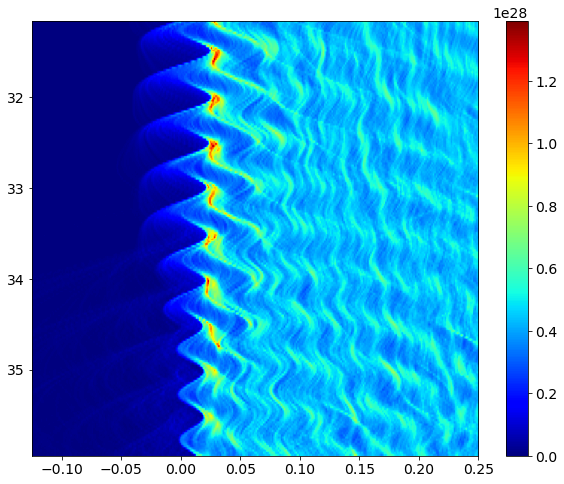

In [23]:
t_start = 1300
t_end = 1500
t_max = d.shape[0]
x_max = d.shape[1]
x_start = 2*3950
x_end = 2*4100
EXTENT = [-X_MIN*(x_start-NX//2)/x_max,-X_MIN*(x_end-NX//2)/x_max,T_MAX*t_end/t_max,T_MAX*t_start/t_max]
plt.imshow(d[t_start:t_end, x_start:x_end], aspect="auto", extent=EXTENT, cmap="jet")
cmap = colors.ListedColormap(["white"])
plt.colorbar(cmap=cmap)

# Fourier Analysis

In [24]:
def get_pulse(t):
    if t<0:
        return 0
    elif t< LAS_TIME:
        return np.sin(omega0*t)*np.exp(-0.5*((t-0.5*LAS_TIME)/(LAS_TIME*0.2))**2)
    else:
        return 0

T_O = np.arange(0,len(ALL_FILES))*DT
pulse = [get_pulse(t) for t in T_O]

In [25]:
node2 = 8000/NX*40
node1 = 4000/NX*40
node_t_1 = node1*tau
node_t_2 = node2*tau
node_t_1, node_t_2

(3.3356409519815204e-14, 6.671281903963041e-14)

In [26]:
pulse_1= [get_pulse(t-node_t_1) for t in T_O]
pulse_2= [get_pulse(t-node_t_2) for t in T_O]

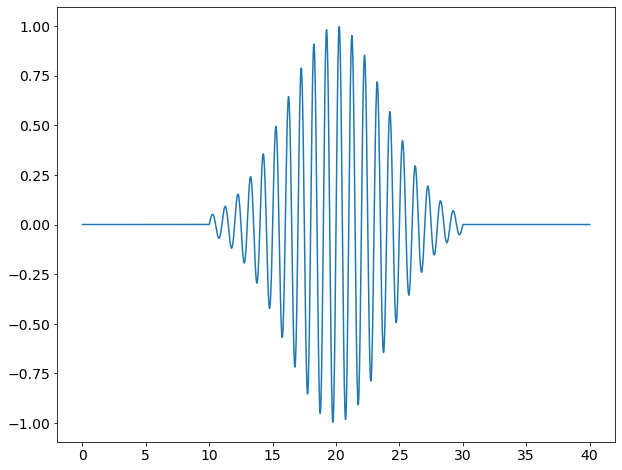

In [27]:
plt.plot(T_O/tau, pulse_1)

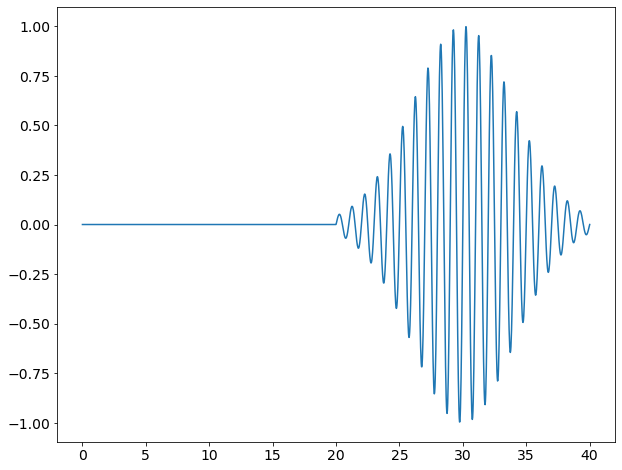

In [28]:
plt.plot(T_O/tau, pulse_2)

In [29]:
pulse = np.array(pulse)

In [30]:
pulse_1 = pulse_1/np.max(pulse_1)
pulse_2 = pulse_2/np.max(pulse_2)
Et0 = Et0/np.max(Et0)
Et1 = Et1/np.max(Et1)
Et2 = Et2/np.max(Et2)

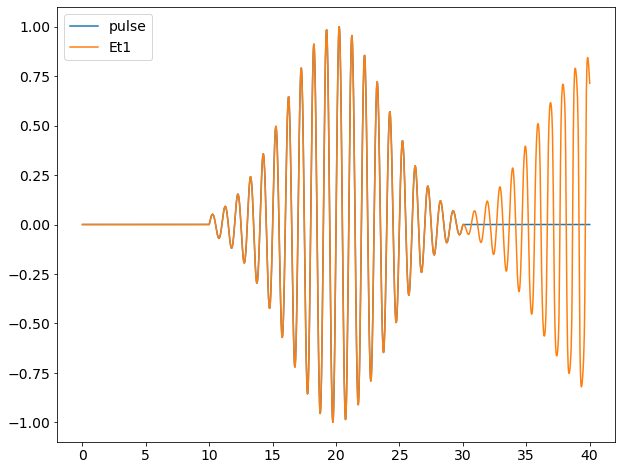

In [31]:
plt.plot(T, pulse_1, label="pulse")
plt.plot(T, Et1, label="Et1")
plt.legend();


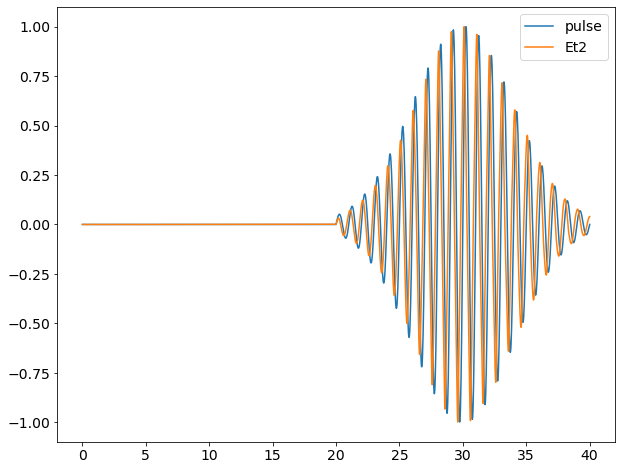

In [32]:
plt.plot(T, pulse_2, label="pulse")
plt.plot(T, Et2, label="Et2")
plt.legend();


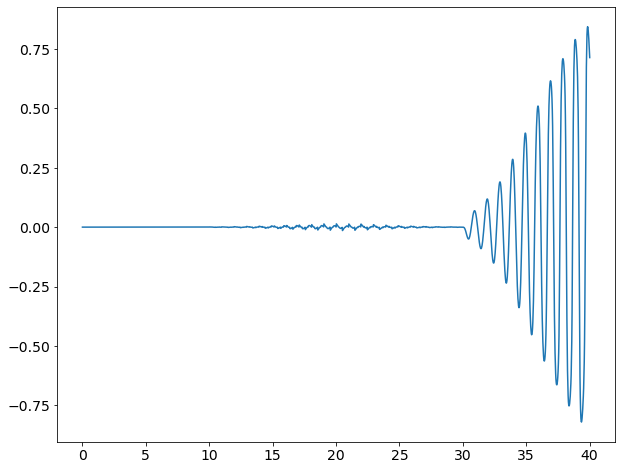

In [33]:
plt.plot(T, Et1-pulse_1, label="Et1-pulse_1")

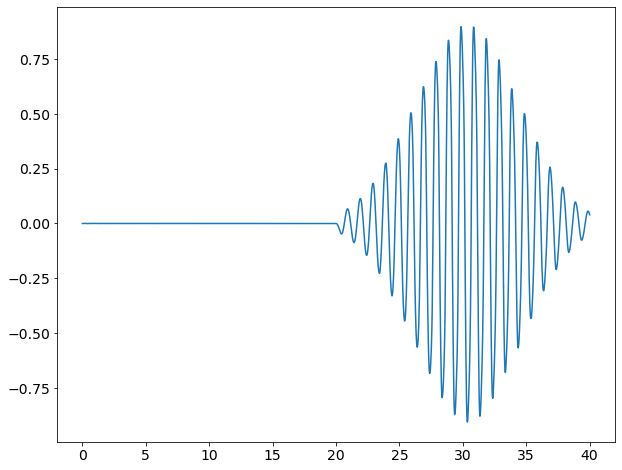

In [34]:
plt.plot(T, Et2-pulse_2, label="Et2-pulse_2")

## FT

In [35]:
y0 = np.fft.fft(Et0)
y1 = np.fft.fft(Et1-pulse_1)
y2 = np.fft.fft(Et2-pulse_2)
y3 = np.fft.fft(Et1)
y4 = np.fft.fft(Et2)

In [36]:
y3_shift = np.fft.fftshift(y3)
y4_shift = np.fft.fftshift(y4)
y1_shift = np.fft.fftshift(y1)
y2_shift = np.fft.fftshift(y2)
y0_shift = np.fft.fftshift(y0)
y1_f = np.abs(y1_shift)
y2_f = np.abs(y2_shift)
y3_f = np.abs(y3_shift)
y4_f = np.abs(y4_shift)
y0_f = np.abs(y0_shift)

In [37]:
omega = np.linspace(-omega_max/2, omega_max/2, len(ALL_FILES))

In [38]:
omega_max/omega0

41.69551189976901

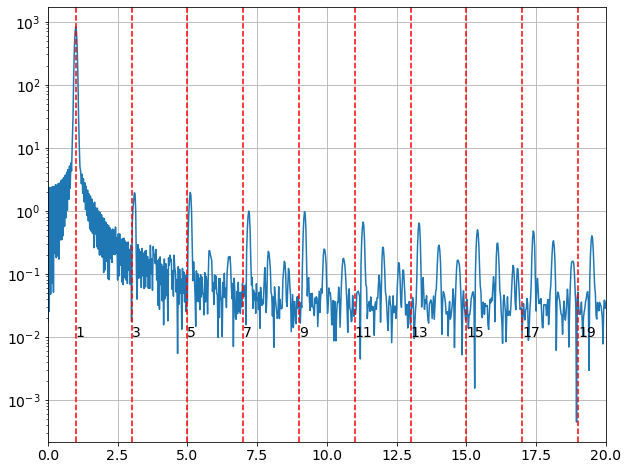

In [39]:
plt.plot(omega/omega0, 2*np.abs(y0_f)*2)
plt.yscale("log")
points = np.arange(1,21,2)
for p in points:
    plt.axvline(p, color="red", linestyle="--")
    plt.annotate(f"{p}", (p, 1e-2))
plt.xlim(0,20)
plt.grid()

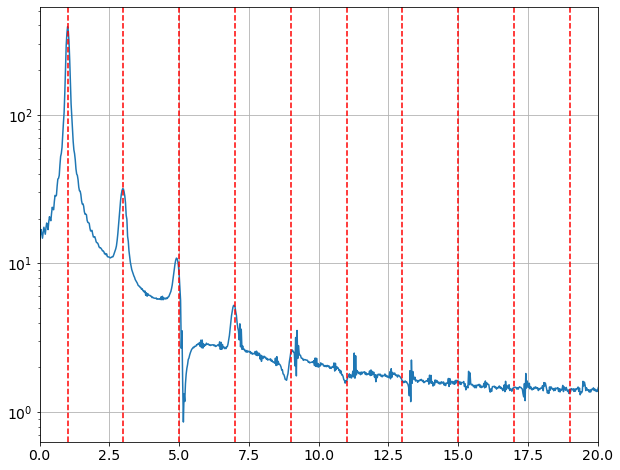

In [40]:
plt.plot(omega/omega0, 2*np.abs(y1_f)*2)
plt.yscale("log")
points = np.arange(1,21,2)
for p in points:
    plt.axvline(p, color="red", linestyle="--")
    plt.annotate(f"{p}", (p, 1e-2))
plt.xlim(0,20)
plt.grid()

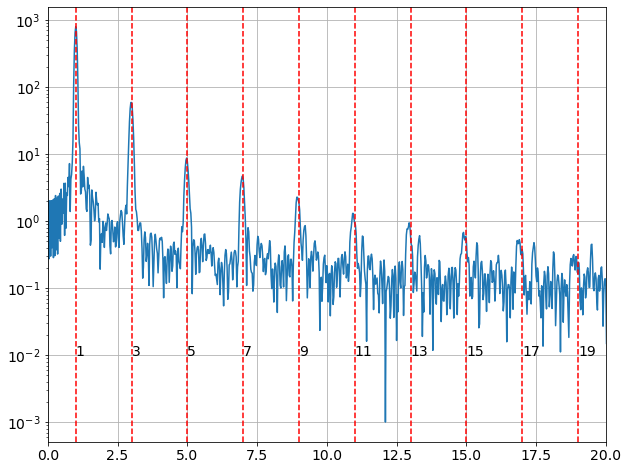

In [41]:
plt.plot(omega/omega0, 2*np.abs(y2_f)*2)
plt.yscale("log")
points = np.arange(1,21,2)
for p in points:
    plt.axvline(p, color="red", linestyle="--")
    plt.annotate(f"{p}", (p, 1e-2))
plt.xlim(0,20)
plt.grid()

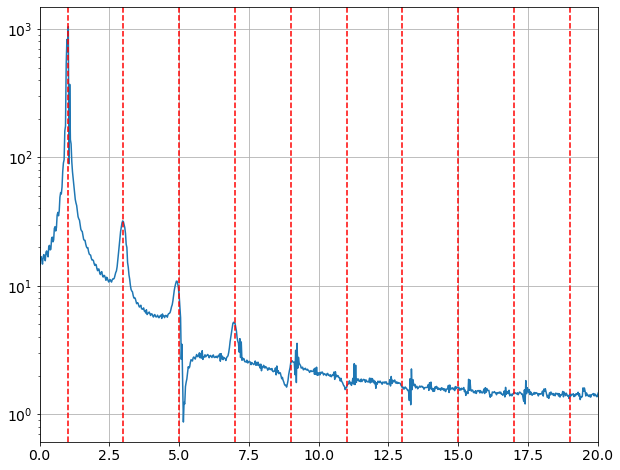

In [42]:
plt.plot(omega/omega0, 2*np.abs(y3_f)*2)
plt.yscale("log")
points = np.arange(1,21,2)
for p in points:
    plt.axvline(p, color="red", linestyle="--")
    plt.annotate(f"{p}", (p, 1e-2))
plt.xlim(0,20)
plt.grid()

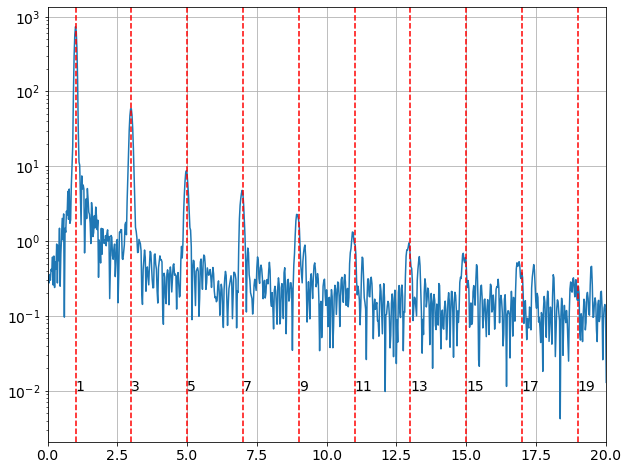

In [43]:
plt.plot(omega/omega0, 2*np.abs(y4_f)*2)
plt.yscale("log")
points = np.arange(1,21,2)
for p in points:
    plt.axvline(p, color="red", linestyle="--")
    plt.annotate(f"{p}", (p, 1e-2))
plt.xlim(0,20)
plt.grid()